In [1]:
# MIT License
#
# @title Copyright (c) 2024 Mauricio Tec { display-mode: "form" }

# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.


# Welcome to the HDSI Winter Workshop on LLMs as Autonomous Agents


<img src="https://drive.google.com/uc?export=view&id=1q4SGPmn6sWQhskt4D-1D09q_6C9FDz_L" alt="drawing" width="400"/>


# **Part II: Grounding Agents with Fine-tuning and RL**

<a target="_blank" href="https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/llm-agents-part2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Expected completion time: 1:30 hours


## March 7, 2025  <br> Mauricio Tec



**TL;DR** Our previous tutorial gave us the tools to understand agentic LLM workflows. In this tutorial we will talk about learning. We will use fine tuning and reinforcement learning to improve the LLM for specific tasks.

🔥🔥 📚 **Let's learn how to learn** 📚🔥🔥

*Familiarity with PyTorch models is assumed.*


<br>


<img src="https://drive.google.com/uc?export=view&id=1e3nRrx9IT5BjhWFwk1VKHS-a6m0EoMhc" alt="drawing" width="450"/>


See also:

* [Previous (Part I): Introduction to Agentic Frameworks](https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/llm-agents-part1.ipynb)
* [Pre-assignment: Setup LLM Access & API Keys](https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/pre-assignment.ipynb)


# Software Prerequisites & Setup


## Utility Function: Markdown Printing

As in part I, we will define a very simple utility function to print nicely in a colab notebook environment with Markdown. This is not really needed, but it will make some output visualizations easier and nicer.


In [2]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

test = "`This is code`. *This is italics*. **This is bold**."
printmd(test)

`This is code`. *This is italics*. **This is bold**.

In [3]:
# @title Mount Google Colab
# @markdown While not needed, this will help us to save outputs and checkpoints
import os
from google.colab import drive
drive.mount('/content/drive')

# Create a target dir to save files
target_dir = '/content/drive/MyDrive/hdsi-winter-workshop/'
os.makedirs(target_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install Requirements

* The main tool will be `PyTorch`, which is the most common deep learning research framework.

<img src="https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png" alt="drawing" width="300"/>


* Our second main tool, more specific to this tutorial, is the  `transformers` library, which provides access to various open-source `LLMs` as PyTorch. With transformers we have access to their internals, code, and weights.
* The `HuggingFace` tool ecosystem includes various other packages that we will need to be able to manipulate such massive models, which go beyond standard neural network training. Examples include `peft`, `bitsandbytes`, `accelerate`. For reinforcement learning and finetuning, we will use the `trl` library, which includes functionality for finetuning.
* Lastly, we will continue using the `smolagents` library for implementing the basic react loop functionality.

<img src="https://drive.google.com/uc?export=view&id=1RGuWtGHW88vk7T5JyMjnepG9YzwKJEVM" alt="drawing" width="600"/>


* 🎮 Let's play a game! While the techniques we will study apply to many environments. We will base our tutorial one nice text-based game called `TextWorld`.  

<img src="https://drive.google.com/uc?export=view&id=1fdfrUd4gxsute0b6qRdZ5d6l4y16D6UK" alt="drawing" width="600"/>


In [4]:
%pip install -q -U \
  transformers[torch,accelerate] \
  trl[peft] \
  bitsandbytes \
  textworld-express

## 🤗 The HuggingFace Transformer Model 🤗

We will be working with the `meta-llama/Llama-3.2-1B-Instruct` model. Let us check access.

If your access is restricted, check out the [pre-assignment notebook](https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/pre-assignment.ipynb) for more details on setting up access to Llama 3.2 on HuggingFace.


In [5]:
# Retrieve open AI key from Colab secrets
import os
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [6]:
# @title Test HF Model

import transformers
import peft
import torch

# Change logging of transformer to avoid so many warnings
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

model_id = "meta-llama/Llama-3.2-1B-Instruct"
# You can also try the 3B model, But you'll need a slightly larger GPU than the T4 entry-level Colab one

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    # quantization_config=transformers.BitsAndBytesConfig(load_in_8bit=True),
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    device_map="auto",
    use_cache=True,
)

tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Some info about the model
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in LLM: {num_params:,}")

# compute bytes in memory of model
obj_mem  = model.get_memory_footprint()
obj_mem_gb = obj_mem / (1024**3)
print(f"Memory footprint of model: {obj_mem_gb:.2f} gigabytes")


# Utility to generate text
def call_model(prompt, model, verbose=False, **kwargs):
    """Simple function to call the model."""
    # First empty cache
    torch.cuda.empty_cache()

    # Get model device
    device = next(model.parameters()).device

    # First convert to conversational form and use the chat tempalte
    messages= [{"role": "user", "content": prompt}]

    # Tokenize
    full_prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    inputs = tokenizer(full_prompt, return_tensors="pt").to(device)

    if verbose:
        print(f"== Prompt after applying chat template:\n{full_prompt}")
        print(f"== Tokenized promopt ==\n{inputs.input_ids}")

    # Generate
    with torch.no_grad():
      gen = model.generate(
          **inputs,
          max_new_tokens=100,
          eos_token_id=tokenizer.eos_token_id,
          **kwargs,
      )[0]

    # Remove generation tokens
    num_inputs = len(inputs["input_ids"][0])
    gen = gen[num_inputs:]

    if verbose:
        print(f"== Generated tokens ==\n{gen}")

    # Decode to text
    result = tokenizer.decode(gen, skip_special_tokens=True)

    if verbose:
        print(f"== Decoded text ==\n{result}")

    return result

call_model("What is the capital of France?", model, verbose=True);

Number of parameters in LLM: 1,235,814,400
Memory footprint of model: 2.30 gigabytes
== Prompt after applying chat template:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 06 Mar 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

What is the capital of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>


== Tokenized promopt ==
tensor([[128000, 128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,
           2696,     25,   6790,    220,   2366,     18,    198,  15724,   2696,
             25,    220,   2705,   2947,    220,   2366,     20,    271, 128009,
         128006,    882, 128007,    271,   3923,    374,    279,   6864,    315,
           9822,     30, 128009, 128006,  78191, 128007,    271]],
       device='cuda:0')
== Generated tokens ==
tensor([   791,   6864,    315,   9822,    374,  12366,     13, 128009],
       device='cuda:0')
== Decoded text ==
The capital of France is Paris.


## 🎮 The TextWorld Interactive Environment 🎮

Let's start the fun 🤩. We will play the`twc` (TextWorld common sense) games. There is the documentation's description of the game:

> `TextWorld Common Sense (twc)`

> Text game agents frequently learn the dynamics of environment --
such as the need to open a door before one can move through it --
from interacting with the environment itself, rather than using a pre-existing
knowledge base of common sense facts or object affordances that would speed
task learning. TextWorld Commonsense [Murugesan etal., 2021](https://arxiv.org/abs/2010.03790)
aims to evaluate agents on common sense knowledge that can not be directly learned from the
environment by providing agents a clean-up task where the agent must place
common household objects (e.g., a dirty dish) in their canonical locations
(e.g., the dishwasher) that can be found in knowledge bases such as ConceptNet.
Separate lists of objects are used in the training, development, and test sets,
meaning the agent can not learn object locations from the training set alone,
and must rely on an external common sense knowledge base to perform well on the
development and test sets. TextWorld Commonsense benchmark has three task
difficulty levels, with the easiest including a single location and object to
put away, while the hard setting includes up to p to 11 locations and any number
of task-relevant and distractor objects.

In [7]:
import random
from textworld_express import TextWorldExpressEnv


#  Textworld game Engine Creator
def env_factory(
    gameName: str = "twc",
    gameParams: str = "numLocations=3,includeDoors=1,numItemsToPutAway=4",
    time_limit: int = 12,
    gold_path: bool = False,
):
    env = TextWorldExpressEnv(envStepLimit=time_limit)
    env.load(gameName=gameName, gameParams=gameParams)
    return env

# Create new game instance
env = env_factory()
obs, infos = env.reset(seed=1234, gameFold="train")


# Take some random steps and collect experience in history
history = []
history.append("## Welcome to TextWorld")
history.append(f"`<Task>`: {env.getTaskDescription()}")
history.append(f"`<Starting Obs>`: {obs}")

for step_id in range(10):
    history.append(f"**Step {step_id + 1}**")

    # Select a random valid action
    randomAction = random.choice(infos['validActions'])

    # Take that action
    obs, reward, done, infos = env.step(randomAction)

    # Display action and the game's feedback.
    history.append(f"`<Valid Actions>` {infos['validActions']}")
    history.append(f"`<Action>` {randomAction}")
    history.append(f"`<Obs>` {obs}")
    history.append(f"`<Reward>` {reward:0.2f}")

history = "\n\n".join(history)
printmd(history)

## Welcome to TextWorld

`<Task>`: Your task is to pick up objects, then place them in their usual locations in the environment.

`<Starting Obs>`: You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

**Step 1**

`<Valid Actions>` ['move east', 'close door to east', 'open door to east', 'look around', 'inventory', 'take clean plate']

`<Action>` inventory

`<Obs>` Inventory: 
  Your inventory is currently empty.


`<Reward>` 0.00

**Step 2**

`<Valid Actions>` ['look around', 'close door to east', 'open door to east', 'inventory', 'move east', 'take clean plate']

`<Action>` move east

`<Obs>` You can't move there, the door is closed. 

`<Reward>` 0.00

**Step 3**

`<Valid Actions>` ['inventory', 'open door to east', 'take clean plate', 'look around', 'close door to east', 'move east']

`<Action>` close door to east

`<Obs>` That is already closed. 

`<Reward>` 0.00

**Step 4**

`<Valid Actions>` ['take clean plate', 'close door to east', 'move east', 'look around', 'open door to east', 'inventory']

`<Action>` look around

`<Obs>` You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

`<Reward>` 0.00

**Step 5**

`<Valid Actions>` ['inventory', 'move east', 'take clean plate', 'look around', 'open door to east', 'close door to east']

`<Action>` inventory

`<Obs>` Inventory: 
  Your inventory is currently empty.


`<Reward>` 0.00

**Step 6**

`<Valid Actions>` ['open door to east', 'inventory', 'move east', 'close door to east', 'look around', 'take clean plate']

`<Action>` open door to east

`<Obs>` You open the plain door, revealing the kitchen. 

`<Reward>` 0.00

**Step 7**

`<Valid Actions>` ['open cutlery drawer', 'take potato peeler', 'close door to west', 'open trash can', 'open fridge', 'inventory', 'look around', 'open kitchen cupboard', 'open dishwasher', 'move west', 'open door to west', 'move east']

`<Action>` move east

`<Obs>` You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a potato peeler. 
To the East you see the living room. Through an open plain door, to the West you see the pantry. 

`<Reward>` 0.00

**Step 8**

`<Valid Actions>` ['close door to west', 'look around', 'open door to west', 'move west', 'inventory', 'open trash can', 'open kitchen cupboard', 'close cutlery drawer', 'open fridge', 'take potato peeler', 'move east', 'open dishwasher']

`<Action>` open cutlery drawer

`<Obs>` You open the cutlery drawer. It's empty inside.

`<Reward>` 0.00

**Step 9**

`<Valid Actions>` ['open trash can', 'open door to west', 'open dishwasher', 'take potato peeler', 'move west', 'look around', 'open fridge', 'move east', 'open cutlery drawer', 'open kitchen cupboard', 'inventory', 'close door to west']

`<Action>` close cutlery drawer

`<Obs>` You close the cutlery drawer.

`<Reward>` 0.00

**Step 10**

`<Valid Actions>` ['close door to west', 'open fridge', 'open trash can', 'inventory', 'take potato peeler', 'move east', 'move west', 'look around', 'open door to west', 'open cutlery drawer', 'open kitchen cupboard', 'close dishwasher']

`<Action>` open dishwasher

`<Obs>` You open the dishwasher. It's empty inside.

`<Reward>` 0.00

# I. Benchmarking the Baseline Agents

Using what we learned in the previous part, let's evaluate how well the basic and chain of thought agents perform in TextWorld.


### Building Functionality: Creating the Planning and Action Steps

We will now implement some utility functions that will allow the agent to play the game.

#### *Coding Plan*

* 📜 **Build the task prompt** – Use `build_task_prompt(history, valid_actions)` to construct the task prompt, incorporating history and valid actions.
* 📝 **Generate a plan** – Use `planning_step(task_prompt, previous_plan=None)` to create an initial plan and revise it as new observations are made.
* 🤖 **Select the next action** – Use `action_step(task_prompt, valid_actions, example_thoughts=None)` to determine the next valid action, optionally incorporating a thought process.
* 🎯 **Ensure valid actions** – Use `extract_valid_action(response, valid_actions)` to validate and correct actions based on the valid action list.

In [8]:
def build_task_prompt(memory):
    """Builds the task prompt from memory, including examples."""
    return "\n\n".join(memory) + "Answer the questions below. Give all answers using plain text or bullet points. Don't use hastags `#`. Prefer short answers."


def planning_step(model, task_prompt, previous_plan=None):
    """Generates a plan."""
    plan_prompt = task_prompt + "### Question\nOutline a plan to solve the task.\n"

    return call_model(plan_prompt, model)


def action_step(model, task_prompt, valid_actions, thinking=False):
    """Generates an action. If example thoughts are provided, it first generates thoughts before selecting an action."""

    # Use chain of thought if needed
    if thinking:
        thought_prompt = task_prompt + (
            "\n\n###Question\nLet's think step by step before deciding the best next action.\n"
            f"The valid actions are: {','.join(valid_actions)}\n"
            "\n\n###Example:\nMy task is to move misplaced objects to their usual locations. I just arrived to the kitchen and my inventory has a kitchen knife. Then, I must drop the kitcken knife here.\n"
        )
        thoughts = call_model(thought_prompt, model)
        task_prompt += f"\n\n[Thoughts] {thoughts}"
    else:
        thoughts = ""

    # Obtain action, ensuring validity
    task_prompt += (
        "\n\nNow, choose exactly one valid action from the list and no additional information.\n"
         f"The valid actions are: {','.join(valid_actions)}\n"
         f"Example answer: {random.choice(valid_actions)}"
    )
    response = call_model(task_prompt, model).strip()
    for chars in ["[", "]", "`", '"', "'", "\n", ":"]:
        response = response.replace(chars, "")
    action = extract_valid_action(model, response, valid_actions)

    return action, thoughts


def extract_valid_action(model, response, valid_actions):
    """Ensures the extracted action is valid, querying the LLM if needed."""
    action = response.strip("[]`:").strip()
    if action in valid_actions:
        return action

    correction_prompt = (
        f"The agent responded: '{response}'. However, this is not a valid action.\n"
        f"The valid action list is {valid_actions}, extract the closest correct action.\n"
        "If the response contains unnecessary words like 'You move north to take the ball.', extract only 'move north'.\n"
        "If multiple optimal actions where suggested, choose the first valid action.\n"
        "Example corrections:\n"
        "- You open the cabinet.' → open shoe cabinet\n"
        "- 'Check my bag.' → inventory\n"
        "- Move in the east direction to take pick up shows and go west.' → move east\n"
        "- move south move north → move south\n"
        "- move north, pick up shoes → move north\n"
        "- pick up shoes, move north → pick up shoes\n"
        "Return only the corrected action from the valid action list without extra words.\n"
        "For instance, in the last example, your answer should simply be: pick up shoes"
    )
    corrected_action = call_model(correction_prompt, model).strip()
    return corrected_action

Let's now test these function in a single decision step.

In [9]:
# Initialize environment
env = env_factory()
obs, infos = env.reset(gameFold="train")

# Initialize memory
valid_actions = infos['validActions']
memory = [
    "## Welcome to TextWorld",
    f"`[Task]`: {env.getTaskDescription()}",
    f"`[Starting Obs]`: {obs}",
    f"`[Valid Actions]`: {valid_actions}",
]

# Initialize prompt
task_prompt = build_task_prompt(memory)

# # Start decision making
# plan = planning_step(model, task_prompt)
# memory.append(f"`[Initial Plan]` {plan}")

action, thoughts = action_step(model, task_prompt, valid_actions, thinking=True)

obs, reward, done, infos = env.step(action)

memory.append(f"`[Thoughts]` {thoughts}")
memory.append(f"`[Action]` {action}")
memory.append(f"`[Obs]` {obs}")
memory.append(f"`[Reward]` {reward:0.2f}")

printmd("\n\n".join(memory))

## Welcome to TextWorld

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a copybook. There is also a makeup kit. 
To the South you see a closed wood door. To the West you see the kitchen. 

`[Valid Actions]`: ['move west', 'take copybook', 'move south', 'inventory', 'look around', 'close door to south', 'open door to south', 'take makeup kit', 'open wastepaper basket']

`[Thoughts]` To start, I will take the copybook from the side table in the living room.

`[Action]` inventory

`[Obs]` Inventory: 
  Your inventory is currently empty.


`[Reward]` 0.00

### Playing a Full Episode

Let's put together our functions we created above into a "rollout" loop to play a full episode.

*Coding Plan*

* 👾 The game engine must be initiated
* 📖 We ask the agent for an initial plan, and revise it so often.
* 📈 We need to keep adding observations and actions to the memory
* 💸 We need to track the total reward of the agent
* 📀 At each step, we ask the agent for the action to take using the functions we just created in the previous step.


In [10]:
from datetime import datetime # to include time in loop
from typing import Literal  # hint valid arguments to a function
from tqdm.auto import tqdm  # progress bar


def episode_rollout(
    model: transformers.PreTrainedModel,
    gameFold: str = Literal["train", "valditation", "test"],
    thinking: bool = False,
    planning: bool = False,
    planning_interval: int = 3,
    env_factory_options: dict = {},
):
    # Set model in eval mode, no dropout, etc..)
    model.eval()

    # Initialize env
    env = env_factory(**env_factory_options)
    obs, infos = env.reset(gameFold=gameFold)

    # Initialize Memory
    memory = []
    memory.append(f"`[Task]`: {env.getTaskDescription()}")
    memory.append(f"`[Starting Obs]`: {obs}")


    # Make task prompt
    task_prompt = build_task_prompt(memory)

    # Make initial plan
    if planning:
        plan = planning_step(model, task_prompt)
        memory.append(f"`[Initial Plan]`: {plan}")

    # Start loop
    done = False
    total_reward = 0.0
    pbar = tqdm(desc="Episode Progress") # progress bar
    collected_data = []  # useful for training later

    step = 0
    while not done:
        step += 1

        # Update task prompt
        memory.append(f"###  `Action step {step}`")
        memory.append(f"`[Time]` {datetime.now().strftime('%H:%M:%S')}")
        memory.append(f"`[Valid Actions]`: {infos['validActions']}")
        task_prompt = build_task_prompt(memory)

        # Get new action from LLM
        # Update task prompt before action
        action, thoughts = action_step(
            model,
            task_prompt,
            infos['validActions'],
            thinking,
        )

        # Advance the Environment
        obs, reward, done, infos = env.step(action)

        # Update memory
        if thinking:
            memory.append(f"`[Thoughts]`:\n\n{thoughts}")
        memory.append(f"`[Action]`: {action}")
        memory.append(f"`[Reward]`: {reward:0.2f}")
        memory.append(f"`[Obs]`: {obs}")

        if planning and step % planning_interval == 0:
            plan = planning_step(model, task_prompt, plan)
            memory.append(f"`[Updated Plan]`: {plan}")

        # Append experience to data
        collected_data.append((task_prompt, thoughts, action, obs, reward))

        total_reward += reward
        pbar.update(1)

    return memory, collected_data, total_reward


memory, _, _ = episode_rollout(
    model, gameFold="test", thinking=True, env_factory_options=dict(time_limit=5),
)

printmd('\n\n'.join(memory))

Episode Progress: 0it [00:00, ?it/s]

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a dining table, that has nothing on it. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a wet black underpants. 
To the North you see a closed wood door. To the East you see a closed wood door. 

###  `Action step 1`

`[Time]` 15:41:03

`[Valid Actions]`: ['inventory', 'look around', 'open door to east', 'take wet black underpants', 'open dishwasher', 'move east', 'open cutlery drawer', 'move north', 'open trash can', 'close door to east', 'open fridge', 'open door to north', 'close door to north']

`[Thoughts]`:

To start, I will look around the room.

`[Action]`: close door to east

`[Reward]`: 0.00

`[Obs]`: That is already closed. 

###  `Action step 2`

`[Time]` 15:41:04

`[Valid Actions]`: ['take wet black underpants', 'close door to east', 'close door to north', 'inventory', 'move east', 'open dishwasher', 'open door to east', 'look around', 'open cutlery drawer', 'open door to north', 'move north', 'open trash can', 'open fridge']

`[Thoughts]`:

To move the wet black underpants to the usual location, I will first move the wet black underpants to the counter.

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed. 

###  `Action step 3`

`[Time]` 15:41:05

`[Valid Actions]`: ['move east', 'open door to east', 'open dishwasher', 'open trash can', 'open cutlery drawer', 'close door to north', 'close door to east', 'open fridge', 'look around', 'move north', 'inventory', 'open door to north', 'take wet black underpants']

`[Thoughts]`:

To move the wet black underpants to the usual location, I will first move the wet black underpants to the counter.

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed.

To the east you see a closed door. To the north you see a closed door. You can move north.

`[Action]`: move north

`[Reward]`: 0.00



`[Action]`: open fridge

`[Reward]`: 0.00

`[Obs]`: You open the fridge. It's empty inside.

###  `Action step 4`

`[Time]` 15:41:07

`[Valid Actions]`: ['look around', 'close door to east', 'inventory', 'open door to north', 'open door to east', 'close fridge', 'move east', 'open cutlery drawer', 'take wet black underpants', 'open dishwasher', 'move north', 'close door to north', 'open trash can']

`[Thoughts]`:

To move the wet black underpants to the usual location, I will first move the wet black underpants to the counter.

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed. 

###  `Action step 2`

`[Time]` 15:41:08

`[Valid Actions]`: ['move east', 'open door to east', 'open cutl

`[Action]`: open trash can

`[Reward]`: 0.00

`[Obs]`: You open the trash can. It's empty inside.

###  `Action step 5`

`[Time]` 15:41:09

`[Valid Actions]`: ['inventory', 'open cutlery drawer', 'close trash can', 'move north', 'move east', 'open dishwasher', 'open door to north', 'close fridge', 'close door to north', 'close door to east', 'look around', 'take wet black underpants', 'open door to east']

`[Thoughts]`:

To move the wet black underpants to the usual location, I will first move the wet black underpants to the counter.

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed.

###  `Action step 2`

`[Time]` 15:41:10

`[Valid Actions]`: ['move east', 'open door to east', 'open cutlery

`[Action]`: take wet black underpants

`[Reward]`: 0.12

`[Obs]`: You take the wet black underpants.

###  `Action step 6`

`[Time]` 15:41:12

`[Valid Actions]`: ['look around', 'inventory', 'put wet black underpants in dining chair', 'close door to north', 'open dishwasher', 'put wet black underpants in trash can', 'move east', 'move north', 'close door to east', 'put wet black underpants in dining table', 'close fridge', 'put wet black underpants in fridge', 'open cutlery drawer', 'open door to east', 'close trash can', 'open door to north', 'put wet black underpants in counter']

`[Thoughts]`:

To move the wet black underpants to the usual location, I will first move the wet black underpants to the counter.

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed.

###  `Action step 2`

`[Time]` 15:41:13

`[Valid Actions]`: ['move east', 'open cutlery drawer', 'close door to

`[Action]`: open cutlery drawer

`[Reward]`: 0.00

`[Obs]`: You open the cutlery drawer. It's empty inside.

### Benchmark over several episodes

Now the moment of truth 😱. Let's run several episodes and collect the experience.
For the interest of time. We will pre-save these results and load them.
But feel free to re-run.

In [11]:
import json
import requests

## Uncomment to rerun everything, by default, result is pre-saved

# episodes = {"vanilla": [], "thinking": []}

# num_episodes_per_agent = 20

# for agent, results in episodes.items():
#     printmd(f"### Agent {agent}")
#     thinking = (agent == "thinking")

#     for ep in range(num_episodes_per_agent):
#         printmd(f"#### Episode {ep}")
#         memory, data, total_reward = episode_rollout(model, gameFold="test", thinking=thinking)
#         results.append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

# with open(f"{target_dir}/episodes_baseline_agents.json", "w") as f:
#     json.dump(episodes, f)

# Download pre-saved results_baseline_agents.json generated in the previous cell from Github
# Comment following lines if re-running data collection
url = "https://raw.githubusercontent.com/mauriciogtec/hdsi-winter-workshop/refs/heads/main/results_baseline_agents.json"
episodes = json.loads(requests.get(url).text)

### Agent vanilla

#### Episode 0

Episode Progress: 0it [00:00, ?it/s]

#### Episode 1

Episode Progress: 0it [00:00, ?it/s]

#### Episode 2

Episode Progress: 0it [00:00, ?it/s]

#### Episode 3

Episode Progress: 0it [00:00, ?it/s]

#### Episode 4

Episode Progress: 0it [00:00, ?it/s]

#### Episode 5

Episode Progress: 0it [00:00, ?it/s]

#### Episode 6

Episode Progress: 0it [00:00, ?it/s]

#### Episode 7

Episode Progress: 0it [00:00, ?it/s]

#### Episode 8

Episode Progress: 0it [00:00, ?it/s]

#### Episode 9

Episode Progress: 0it [00:00, ?it/s]

#### Episode 10

Episode Progress: 0it [00:00, ?it/s]

#### Episode 11

Episode Progress: 0it [00:00, ?it/s]

#### Episode 12

Episode Progress: 0it [00:00, ?it/s]

#### Episode 13

Episode Progress: 0it [00:00, ?it/s]

#### Episode 14

Episode Progress: 0it [00:00, ?it/s]

#### Episode 15

Episode Progress: 0it [00:00, ?it/s]

#### Episode 16

Episode Progress: 0it [00:00, ?it/s]

#### Episode 17

Episode Progress: 0it [00:00, ?it/s]

#### Episode 18

Episode Progress: 0it [00:00, ?it/s]

#### Episode 19

Episode Progress: 0it [00:00, ?it/s]

### Agent thinking

#### Episode 0

Episode Progress: 0it [00:00, ?it/s]

#### Episode 1

Episode Progress: 0it [00:00, ?it/s]

#### Episode 2

Episode Progress: 0it [00:00, ?it/s]

#### Episode 3

Episode Progress: 0it [00:00, ?it/s]

#### Episode 4

Episode Progress: 0it [00:00, ?it/s]

#### Episode 5

Episode Progress: 0it [00:00, ?it/s]

#### Episode 6

Episode Progress: 0it [00:00, ?it/s]

#### Episode 7

Episode Progress: 0it [00:00, ?it/s]

#### Episode 8

Episode Progress: 0it [00:00, ?it/s]

#### Episode 9

Episode Progress: 0it [00:00, ?it/s]

#### Episode 10

Episode Progress: 0it [00:00, ?it/s]

#### Episode 11

Episode Progress: 0it [00:00, ?it/s]

#### Episode 12

Episode Progress: 0it [00:00, ?it/s]

#### Episode 13

Episode Progress: 0it [00:00, ?it/s]

#### Episode 14

Episode Progress: 0it [00:00, ?it/s]

#### Episode 15

Episode Progress: 0it [00:00, ?it/s]

#### Episode 16

Episode Progress: 0it [00:00, ?it/s]

#### Episode 17

Episode Progress: 0it [00:00, ?it/s]

#### Episode 18

Episode Progress: 0it [00:00, ?it/s]

#### Episode 19

Episode Progress: 0it [00:00, ?it/s]

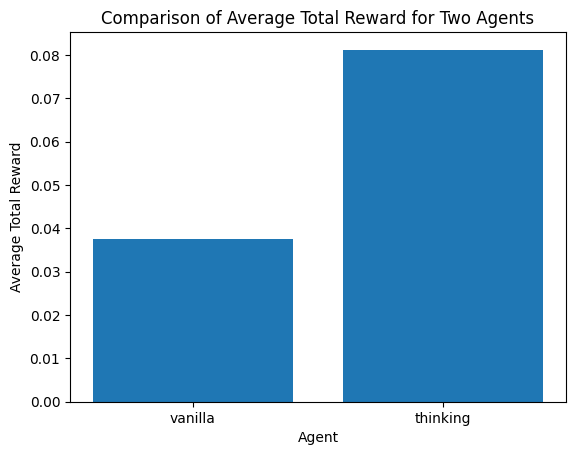

In [12]:
import numpy as np
import matplotlib.pyplot as plt

avg_rewards = {
    a: np.mean([ep["total_reward"] for ep in episodes[a]])
    for a in ["vanilla", "thinking"]
}

# make a bar chart
agents = list(avg_rewards.keys())
rewards = list(avg_rewards.values())

plt.bar(agents, rewards)
plt.xlabel("Agent")
plt.ylabel("Average Total Reward")
plt.title("Comparison of Average Total Reward for Two Agents")
plt.show()

# II. Supervised Fine-tuning (SFT) with Low-rank Adaptation (LORA)

In many problems, it is possible to collect demonstration data and learned an optimal strategy with supervision. For example, this could mean a human playing the game. In our case, text world comes with an engine to generate "gold paths" which help solve the task.

**Learning Plan**

* 📚 We will setup the LLM for efficient training using parameter efficient fine-tuning with LORA [(Hu et al., 2021)](https://arxiv.org/abs/2106.09685).
* 🥇 We will use the gold path engine to create a demonstration dataset
* 🏋️‍♀️ We will use the demonstration dataset for SFT
* 📈 We will evaluate the improved LLM

### 2.1 A primer on SFT and LORA

🕸️ LLMs are just neural networks. In particular, LLMs use the `transformer` architecture introduced in the paper *Attention Is All You Need*  [(Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762). There is a good reason why this paper has over 100k citations ❗️


<figure>
<img src="https://drive.google.com/uc?export=view&id=1isVB0kvxCiE4Mz6eWaDaUu1QDI5BvZNC" alt="drawing" width="600"/>
<figcaption>
<b>Fig.</b> Schemetic representation of the Transformer Architecture and next-token prediction task.<br><em>Original image and blogpost</em>: <a href='https://medium.com/@akash.kesrwani99/understanding-next-token-prediction-concept-to-code-1st-part-7054dabda347'>Understanding Next Token Prediction: Concept To Code: 1st part!</a>
</figcaption>
</figure>


* 🔧 **Fine-tuning** 🔧
  * Fine tuning means updating the weights (parameters) of the neural network using a smaller dataset (aka downstream task).
  * In the context of LLM agents, we may also call this step *grounding* to the task.
  * Finetuning is typically done for far fewer optimization steps than the original training, and usually with smaller learning rates.
  * Finetuning is almost always better than training a model from scratch on the new ata.

* 🎻 **Classic approach** 🎻
  * *Last-layer tuning*: Retraining only the last layer of neural network.
  * *Full finetuning*: Update all weights of the network.
In regular neural network, it is common to update *all* the weights of neural network during finetuning.

* 🦜 **LORA** 🦜
  * LORA takes the best of both finetuning regimes. Few parameters to train, but performs much better than last-layer tuning because it improves the entire neural network.
  * LORA or its many variations have become the standard to finetune LLMs [(Mao et al., 2024)](https://arxiv.org/abs/2407.11046)
  * The main idea is train an *low-rank adapter* as follows, which, for every parameter of the neural network, adds a new weight with fewer free parameters using the magic of low-rank matrix product factorization. The idea is illustrated below.
* 😱 **Worry not!** 😱
  * LORA is easily used without understanding its detailed inner workings.



<figure>
<img src="https://drive.google.com/uc?export=view&id=1HHeFZPdrVQWvA1EbWTHtyAuw_YNJjc-B" alt="drawing" width="800"/>
<figcaption>
<b>Fig.</b> Illustration of LORA.<br><em>Original image</em>: <a href='https://huggingface.co/docs/peft/main/en/developer_guides/lora'>HuggingFace PEFT docs</a>
</figcaption>
</figure>

### 2.3 Configuring the model for LORA training

We now use the `peft` library to setup LORA. Incredibly, only 0.03% of the weights will need to be updated.

In [13]:
from peft import LoraConfig, TaskType

# LORA config
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=4,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none"
)

# Wrap the original model. The wrapped model has fewer trainable paramters
model_lora = peft.get_peft_model(model, peft_config)
model_lora.print_trainable_parameters()

trainable params: 425,984 || all params: 1,236,240,384 || trainable%: 0.0345


### 2.3 Gather the Demonstration dataset

The strategy will be to mimic our previous episode_rollout busing the `env.getGoldActionSequence()` feature and execute that path.

In [14]:
def expert_episode_rollout(
    gameFold: str = Literal["train", "valditation", "test"],
    env_factory_options: dict = {},
):
    # Initialize env
    env = env_factory(**env_factory_options)
    obs, infos = env.reset(gameFold=gameFold, generateGoldPath=True)
    gold_actions = env.getGoldActionSequence()

    # Initialize Memory
    memory = []
    memory.append("## Welcome to TextWorld")
    memory.append(f"`[Task]`: {env.getTaskDescription()}")
    memory.append(f"`[Starting Obs]`: {obs}")

    # Make initial plan
    # Print progress
    pbar = tqdm(desc="Episode Progress")

    # Collected prompt/action/reward triples for training
    collected_data = []

    # Start loop
    done = False
    total_reward = 0.0

    step = 0
    while not done:
        # Update task prompt
        memory.append(f"***`Action step {step}`**")
        memory.append(f"`[Time]` {datetime.now().strftime('%H:%M:%S')}")
        memory.append(f"`[Valid Actions]`: {infos['validActions']}")
        task_prompt = build_task_prompt(memory)

        # Execute gold path action
        action = gold_actions[step]

        # Advance the Environment
        obs, reward, done, infos = env.step(action)

        # Update memory
        memory.append(f"`[Action]`: {action}")
        memory.append(f"`[Reward]`: {reward:0.2f}")
        memory.append(f"`[Obs]`: {obs}")

        collected_data.append((task_prompt, "", action, reward))  # empty for the thoughts

        total_reward += reward
        step += 1
        pbar.update(1)

    return memory, collected_data, total_reward

In [15]:
episodes['expert'] = []

num_episodes_per_agent = 20

for ep in range(num_episodes_per_agent):
    memory, data, total_reward = expert_episode_rollout(gameFold="train")
    episodes['expert'].append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

mean_reward_expert = np.mean([ep["total_reward"] for ep in episodes["expert"]])
print(f"Mean reward for expert: {mean_reward_expert}")

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Mean reward for expert: 0.79375


## 2.3 Finetuning with next-token prediction

First, combine all the expert data.


In [16]:
# 1. Combine all the data
data_list = []
for ep in episodes["expert"]:
    for prompt, _, action, _ in ep["data"]:
        data_list.append({"prompt": prompt, "action": action})
data_list[0]

{'prompt': "## Welcome to TextWorld\n\n`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.\n\n`[Starting Obs]`: You are in the laundry room. In one part of the room you see a bench, that has nothing on it. There is also a work table, that has nothing on it. You also see a clothes drier that is closed. In another part of the room you see a laundry basket, that has nothing on it. In one part of the room you see a washing machine that is closed. There is also a blue coat. You also see a dirty white T-shirt. \nTo the North you see a closed wood door. \n\n***`Action step 0`**\n\n`[Time]` 15:56:41\n\n`[Valid Actions]`: ['open door to north', 'take blue coat', 'move north', 'inventory', 'look around', 'open clothes drier', 'close door to north', 'take dirty white T-shirt', 'open washing machine']Answer the questions below. Give all answers using plain text or bullet points. Don't use hastags `#`. Prefer short answers.",
 'action': 'look arou

Now, before training, let's show the loss will be computed in each training
step.

☣️️ *Warning*.  It's easy to miss adding and end of text token `<|eot_id|>` after the action. Not doing so would result in endless generation.

In [26]:
prompt, action = data_list[0]["prompt"], data_list[0]["action"]
action_with_eot = action + "<|eot_id|>" # !!!! Easy to miss
tokenized_prompt = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")[0]
tokenized_action = tokenizer(action_with_eot, return_tensors="pt").input_ids.to("cuda")[0]

print(f"> Prompt: {prompt[:50]}\n")
print(f"> Tokenized Prompt: {tokenized_prompt[:20]}\n")
print(f"> Action: {action}\n")
print(f"> Tokenized Action: {tokenized_action}\n")

# concatenate prompt/action that will be the input to the language model for next
# token prediction. We don't need to include the last token of the action, since
# it is only used as a label for the next token prediction later.
device = "cuda" if torch.cuda.is_available() else "cpu"
input_ids = torch.cat([tokenized_prompt, tokenized_action[:-1]]).to(device)

# eval LLM - we need the extra dimension since the model expects a batch
# this is achieved by unsqueeze(0)
outputs = model_lora(input_ids.unsqueeze(0))
print(f"> Model outputs: {outputs}")

# Now we will compute the next token prediction loss, but only on the last tokens
# for the action.
# The loss is the cross entropy with the logits and the true next tokens (i.e., the action tokens)
num_action_tokens = len(tokenized_action)
next_token_logits = outputs.logits[0, -num_action_tokens:]
loss = torch.nn.functional.cross_entropy(next_token_logits, tokenized_action)
print(f"> Cross entropy loss Loss: {loss:.2f}")

# clean up
del outputs, loss, next_token_logits
torch.cuda.empty_cache()

> Prompt: ## Welcome to TextWorld

`[Task]`: Your task is to

> Tokenized Prompt: tensor([128000,    567,  20776,    311,   2991,  10343,    271,     63,     58,
          6396,     60,  45722,   4718,   3465,    374,    311,   3820,    709,
          6302,     11], device='cuda:0')

> Action: look around

> Tokenized Action: tensor([128000,   7349,   2212, 128009], device='cuda:0')

> Model outputs: CausalLMOutputWithPast(loss=None, logits=tensor([[[ 2.9590,  3.7402,  7.1758,  ..., -1.3008, -1.3008, -1.3008],
         [ 4.0312,  0.9658,  5.1719,  ..., -4.1797, -4.1797, -4.1797],
         [14.4531,  4.4336,  3.0176,  ..., -1.4795, -1.4795, -1.4795],
         ...,
         [ 3.0020,  3.6699,  6.6953,  ..., -1.3945, -1.3945, -1.3945],
         [ 6.8867,  3.7832,  3.1836,  ..., -1.6426, -1.6436, -1.6416],
         [ 7.3320,  5.3906,  2.7227,  ..., -1.9746, -1.9746, -1.9746]]],
       device='cuda:0', dtype=torch.float16), past_key_values=DynamicCache(), hidden_states=None, attentions=None

🏋️‍♀️ **We are ready to train**🏋️‍♀️ All that is left is to compute the loss and call the optimizer ineach step.

𝝯 **Gradient accumulation** 𝝯 We did not implement batches, which is typically used to improve training. But we can use a very simple trick called gradient accumulation. This trick is handy particularly with larger models when batched training does not fit in memory.


In [27]:
import accelerate


def train(model, tokenizer, data_list, epochs=20):
    """
    Train function that ensures memory is freed after training.

    Args:
        model (torch.nn.Module): The model to be trained.
        data_list (list): The dataset containing prompts and actions.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for processing text inputs.
        optimizer (torch.optim.Optimizer): The optimizer for training.
        accelerator (accelerate.Accelerator): The accelerator for distributed training.
        epochs (int, optional): Number of epochs. Defaults to 20.
    """
    # Set model in train mode (e.g., dropout on)
    model.train()

    # standard choice of optimizer
    optimizer = torch.optim.AdamW(
        model_lora.parameters(),
        lr=2e-5,
        betas=(0.9, 0.95),
        eps=1e-8,
        weight_decay=0.1,
    )

    # accelerator for the gradient accumulation and device management
    accelerator = accelerate.Accelerator(gradient_accumulation_steps=4)
    model, optimizer = accelerator.prepare(model, optimizer)
    device = accelerator.device

    # training loop
    for epoch in range(epochs):
        epoch_losses = []

        # random order of data
        indices = np.random.permutation(len(data_list))

        for i in tqdm(range(0, len(data_list), 4)):
            data = data_list[indices[i]]

            # Tokenize inputs and move to device
            prompt_tokens = tokenizer(data["prompt"], return_tensors="pt").input_ids.to(device)[0]
            action_with_eot = action + "<|eot_id|>" # !!!! Easy to miss
            action_tokens = tokenizer(action_with_eot, return_tensors="pt").input_ids.to(device)[0]
            input_ids = torch.cat([prompt_tokens, action_tokens[:-1]])

            # Compute loss with gradient accumulation
            with accelerator.accumulate(model):
                outputs = model(input_ids.unsqueeze(0))
                num_action_tokens = len(action_tokens)
                next_token_logits = outputs.logits[0, -num_action_tokens:]
                loss = torch.nn.functional.cross_entropy(next_token_logits, action_tokens)

            epoch_losses.append(loss.item())
            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

            # free CUDA memory at every step
            torch.cuda.empty_cache()

        print(f"Epoch {epoch+1} | Loss: {np.mean(epoch_losses):.2f}")

    # Set model back to eval
    model.eval()


train(model_lora, tokenizer, data_list, epochs=5)
model_lora.save_pretrained("sft_lora")

# from peft import PeftModel
# model_lora = PeftModel.from_pretrained(model, "sft_lora")


  0%|          | 0/65 [00:00<?, ?it/s]

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

### 2.4 Evaluate SFT policy

In [19]:
# Combine LORA adapter with the original LLM weights
model_merged = model_lora.merge_and_unload()

# Run eval loop with fine-tuned model
new_episodes = {"sft": []}
num_episodes_per_agent = 20

for ep in range(num_episodes_per_agent):
    printmd(f"#### Episode {ep}")
    memory, data, total_reward = episode_rollout(model_merged, gameFold="test", thinking=False)
    new_episodes['sft'].append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

# save results
with open(f"{target_dir}/episodes_sft_agent.json", "w") as f:
    json.dump(new_episodes, f)

#### Episode 0

Episode Progress: 0it [00:00, ?it/s]

#### Episode 1

Episode Progress: 0it [00:00, ?it/s]

#### Episode 2

Episode Progress: 0it [00:00, ?it/s]

#### Episode 3

Episode Progress: 0it [00:00, ?it/s]

#### Episode 4

Episode Progress: 0it [00:00, ?it/s]

#### Episode 5

Episode Progress: 0it [00:00, ?it/s]

#### Episode 6

Episode Progress: 0it [00:00, ?it/s]

#### Episode 7

Episode Progress: 0it [00:00, ?it/s]

#### Episode 8

Episode Progress: 0it [00:00, ?it/s]

#### Episode 9

Episode Progress: 0it [00:00, ?it/s]

#### Episode 10

Episode Progress: 0it [00:00, ?it/s]

#### Episode 11

Episode Progress: 0it [00:00, ?it/s]

#### Episode 12

Episode Progress: 0it [00:00, ?it/s]

#### Episode 13

Episode Progress: 0it [00:00, ?it/s]

#### Episode 14

Episode Progress: 0it [00:00, ?it/s]

#### Episode 15

Episode Progress: 0it [00:00, ?it/s]

#### Episode 16

Episode Progress: 0it [00:00, ?it/s]

#### Episode 17

Episode Progress: 0it [00:00, ?it/s]

#### Episode 18

Episode Progress: 0it [00:00, ?it/s]

#### Episode 19

Episode Progress: 0it [00:00, ?it/s]

In [25]:
episodes['sft'][-1]

{'ep': 19,
 'total_reward': 0.0,
 'memory': ['`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.',
  '`[Starting Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. \nTo the South you see the kitchen. ',
  '###  `Action step 1`',
  '`[Time]` 16:23:44',
  "`[Valid Actions]`: ['open wastepaper basket', 'look around', 'inventory', 'move south']",
  '`[Action]`: open wastepaper basket',
  '`[Reward]`: 0.00',
  "`[Obs]`: You open the wastepaper basket. It's empty inside.",
  '###  

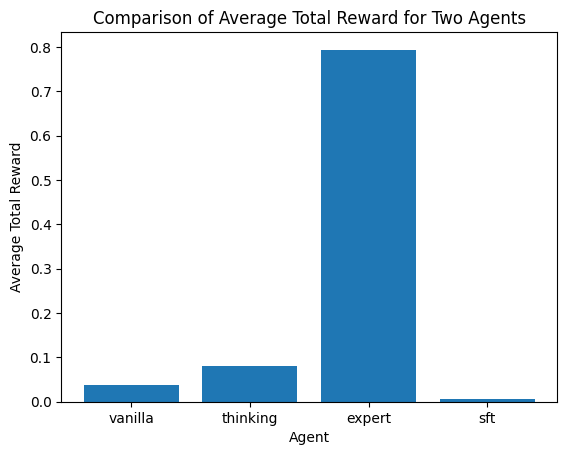

In [20]:
import numpy as np
import matplotlib.pyplot as plt

episodes = episodes | new_episodes

avg_rewards = {
    a: np.mean([ep["total_reward"] for ep in episodes[a]])
    for a in episodes.keys()
}

# make a bar chart
agents = list(avg_rewards.keys())
rewards = list(avg_rewards.values())

plt.bar(agents, rewards)
plt.xlabel("Agent")
plt.ylabel("Average Total Reward")
plt.title("Comparison of Average Total Reward for Two Agents")
plt.show()

In [ ]:
# prompt: Make a cell that sleeps for 6 hours to avoid thenotebook from disconnecting

import time

print("Sleeping for 6 hours...")
time.sleep(6 * 60 * 60)  # Sleep for 6 hours
print("Awake!")


# III. Reinforcement Learning


* While supervised fine-tuning refines LLMs using static datasets, there are some problems:
    * ❌ The SDR objective may be misaligned with the true objective of optimizing reward over time. This small mismatch can reduce overall peformance.
    * 🤔 In fact, SFT has been studied under the name *Behavioral Cloning* in the RL literature, showing the distribution shift between the expert and the learning agent can create several problems [Zare et al., 2023](https://arxiv.org/abs/2309.02473)..


 * 🦾 **Reinforcement Learning** 🦾
  * RL addresses the limitations in SFT by enabling models to learn optimal behaviors through trial and error within interactive settings using a reward signal as feedback. In our case, we will employ RL to train LLMs using the **TextWorld** reward.
  * RL is very hard to train! Here we will make several simplifications to het a small feel of the approach.

**Learning Plan**

1. 🏋️‍♀️ **Overview of RL and Policy Gradients**: Utilize the PPO algorithm to optimize the LLM's decision-making policy.

<!--
By integrating RL, particularly through the use of PPO, we aim to enhance the LLM's capability to learn from interactions within TextWorld, leading to improved decision-making and problem-solving skills in dynamic text-based environments. -->
<!--
<figure>
<img src="https://example.com/ppo_diagram.png" alt="PPO Algorithm Diagram" width="800"/>
<figcaption>
<b>Fig.</b> Illustration of the Proximal Policy Optimization (PPO) algorithm.<br><em>Original image</em>: <a href='https://openai.com/research/proximal-policy-optimization'>OpenAI Research on PPO</a>
</figcaption>
</figure> -->

# Conclusion

### 🤗 What did we learn? 🤔

* 🪜 In an agentic framework, a problem is solved step by step.
* 🆘 LLMs are trained for text completion only. Hence, they struggle at simple operations such as counting or arithmetic which are not aligned with the next-token prediction training.
* 🙇‍♂️ They can immediately solve more complex task by *thinking step by step*. We can implement it with the chain-of-thought prompting technique.
* 🛠️ By leveraging their ability to call tools (code or JSON), we can fill the gap in their abilities. We can implement it with a simple react loop, which underlies most agentic frameworks.


### ➡️ Next steps ➡️

* 💾 More sophisticated memory: in the examples, we simply use the thought, observation, action history as the agent's memory. But for long sequences, we can use a RAG agent. Remember, each token costs money

* 👯 So far, we have approached the problem in a single-agent way. But many agentic frameworks allow to have multiple agents. A simple design is having an orchestrator agent which uses other agents as tools, but there are many use cases and designs.

* 🤖 In the next part of the tutorial, we will cover how to improve an agent performance with fine tuning and reinforcement learning.




<img src="https://drive.google.com/uc?export=view&id=1gA9lNXqJunfai38RS6DSRenuXKFysHW6" alt="drawing" width="400"/>
